# HW 1

In [54]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt

## 1. PCA experiments

In [55]:
# (a) Set up data matrix
url = "https://hastie.su.domains/ElemStatLearn/datasets/zip.digits/train.4"
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')))
data = np.array(c,dtype='float32')
X = data
X.shape

(651, 256)

In [56]:
# (b) Compute the mean of the data matrix and center the data matrix
u = np.mean(X, axis=0)
print('Mean vector:', u.shape)
X_centered = X - u

Mean vector: (256,)


In [57]:
# (c) Compute top k SVD of the centered data matrix
U, s, V = np.linalg.svd(X_centered.T, full_matrices=False)
print('top 5 singular values:', s[:5])

top 5 singular values: [93.81917  80.02715  72.502556 62.02982  52.298912]


(256, 256)


Text(0, 0.5, 'Eigenvalue')

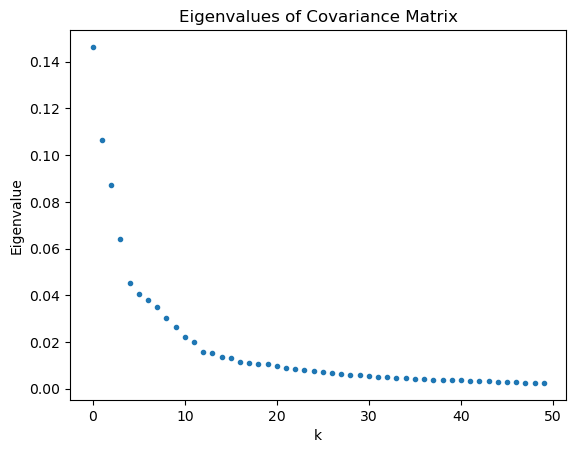

In [58]:
# (d) Plot engienvalue curve for covariance matrix
cov_matrix = np.cov(X_centered.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print(cov_matrix.shape)

plt.plot(eigenvalues[:50]/np.sum(eigenvalues), 'o', markersize=3)
plt.title('Eigenvalues of Covariance Matrix')
plt.xlabel('k')
plt.ylabel('Eigenvalue')

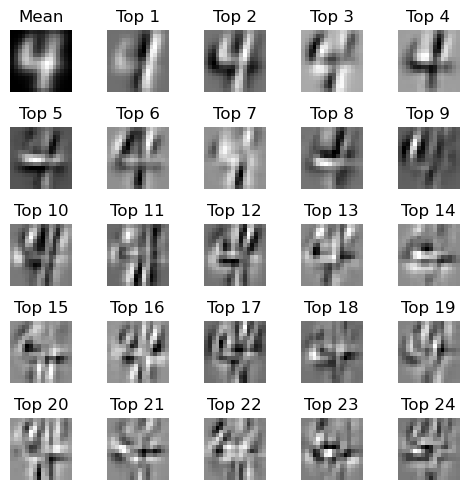

In [59]:
# (e) visualize the mean and top k as left singular vectors U
def plot_top_k(U, k, u=u):
    fig, axs = plt.subplots(5, 5, figsize=(5, 5))
    axs = axs.flatten()
    axs[0].imshow(np.reshape(u, (16, 16)), cmap='gray')
    axs[0].set_title('Mean')
    axs[0].axis('off')
    for i in range(k):
        axs[i+1].imshow(np.reshape(U[:,i], (16, 16)), cmap='gray')
        axs[i+1].set_title('Top ' + str(i+1))
        axs[i+1].axis('off')
    plt.tight_layout()
    plt.show()

plot_top_k(U, 24)

Smallest 25 images:


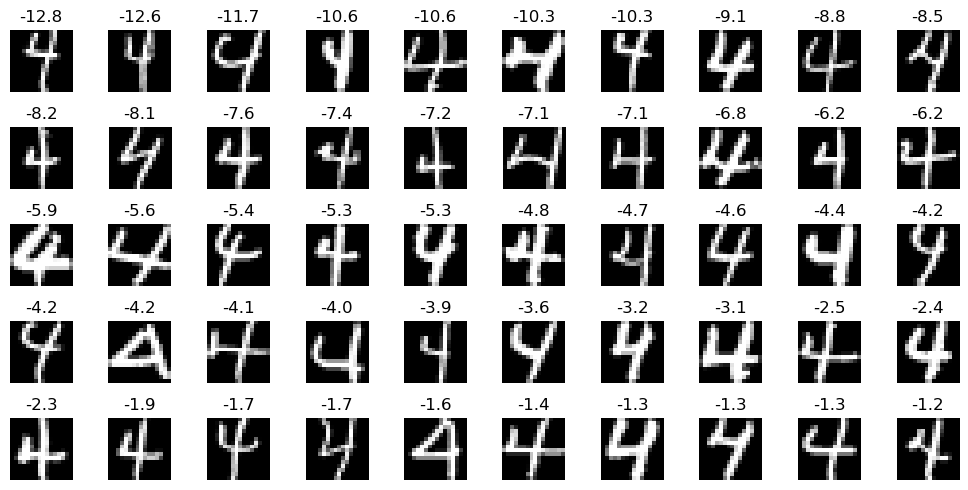

In [62]:
# (f) Order images with the top right singular vectors V
v1 = V[0]
image_v1 = X_centered.T @ v1
idx_sorted = np.argsort(image_v1)
print('Smallest 25 images:')
figure, axs = plt.subplots(5, 10, figsize=(10, 5))
axs = axs.flatten()
for i in range(50):
    axs[i].imshow(np.reshape(X[idx_sorted[i]], (16, 16)), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(round(image_v1[idx_sorted[i]], 1))

plt.tight_layout()
plt.show()

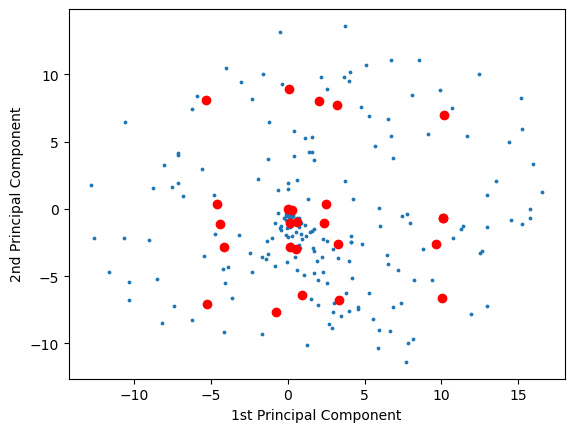

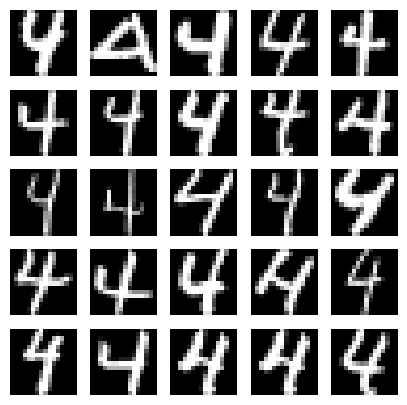

In [63]:
# (g) 2D embedding with the top 2 principal components
fig, ax = plt.subplots()
x_v1 = X_centered.T @ V[0]
y_v2 = X_centered.T @ V[1]
ax.scatter(x_v1, y_v2, s=3)
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')

# Slect a grid of points
v1_percentile = np.quantile(x_v1, [0.1, 0.3, 0.5, 0.7, 0.9], method='nearest')
v2_percentile = np.quantile(y_v2, [0.1, 0.3, 0.5, 0.7, 0.9], method='nearest')

fig, axs = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        point = [v1_percentile[i], v2_percentile[j]]
        point_index = (np.sum((np.array([x_v1, y_v2]).T - point)**2, axis=1)).argmin()
        ax.plot(x_v1[point_index], y_v2[point_index], 'o', c='r')

        imag = np.reshape(X[point_index], (16, 16))
        axs[i, j].imshow(imag, cmap='gray')
        axs[i, j].axis('off')

plt.show()


## 2. MDS

In [65]:
# (a) Set up distance matrix
# New York, Los Angeles, Chicago, Houston, Phoenix, Philadelphia, San Antonio, San Diego, Dallas
D = np.array([
    [0,    2780, 790,  1620, 2450, 94,   1780, 2750, 1540],
    [2780, 0,    2015, 1540, 370,  2715, 1205, 120,  1435],
    [790,  2015, 0,    1080, 1755, 760,  1180, 2050, 925],
    [1620, 1540, 1080, 0,    1170, 1560, 195,  1465, 240],
    [2450, 370,  1755, 1170, 0,    2385, 980,  355,  1070],
    [94,   2715, 760,  1560, 2385, 0,    1675, 2700, 1480],
    [1780, 1205, 1180, 195,  980,  1675, 0,    1315, 275],
    [2750, 120,  2050, 1465, 355,  2700, 1315, 0,    1365],
    [1540, 1435, 925,  240,  1070, 1480, 275,  1365, 0]
])

In [71]:
# (b) Own implementation of MDS
def MDS(D, k):
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n))/n
    K = -0.5 * H @ D @ H
    eigenvalues, eigenvectors = np.linalg.eig(K)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    Z = eigenvectors[:, :k] @ np.diag(np.sqrt(eigenvalues[:k]))
    return Z, eigenvalues, eigenvectors

Z, eigenvalues, eigenvectors = MDS(D, 2)

Text(0, 0.5, 'Normalized Eigenvalue')

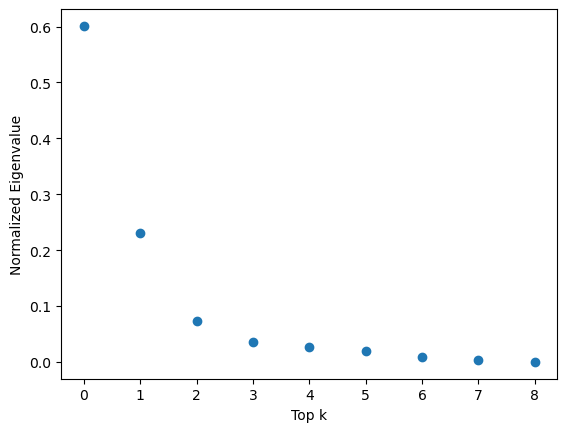

In [74]:
# (c) Plot normalized eigenvalues
n_eigenvalues = eigenvalues/np.sum(eigenvalues)
plt.plot(n_eigenvalues, 'o')
plt.xlabel('Top k')
plt.ylabel('Normalized Eigenvalue')

There are no negative eigenvalues and two of them that are significantly larger than the rest. This suggests that the data can be well represented in a 2D space.

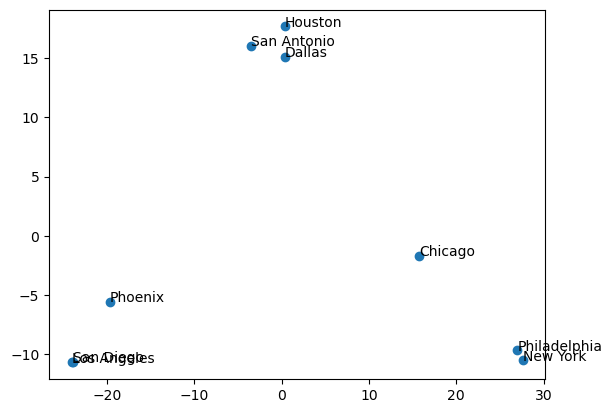

In [70]:
# (d) 2D embedding of the cities
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas']

plt.plot(Z[:, 0], Z[:, 1], 'o')
for i, city in enumerate(cities):
    plt.text(Z[i, 0], Z[i, 1], city)

The plot shows the 2D embedding of the cities. The cities that are closer in the plot are closer in the original distance matrix.